In [36]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [37]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [38]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [39]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [40]:
# reflect an existing database into a new model
# reflect the database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)

# create session
session = Session(engine)

# access the tables and mapped classes
Measurement = Base.classes.measurement
Station = Base.classes.station

/var/folders/29/m8nx20yd0dx5rgcsf8nd2ltc0000gn/T/ipykernel_3700/3775227135.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [41]:
# View all of the classes that automap found
print(Base.classes.keys())

['station', 'measurement']


In [42]:
# Save references to each table
session = Session(engine)
results = session.query(Measurement.date, Measurement.prcp).all()

results

session = Session(engine)
results = session.query(Station.station, Station.name).all()

results

[('USC00519397', 'WAIKIKI 717.2, HI US'),
 ('USC00513117', 'KANEOHE 838.1, HI US'),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US'),
 ('USC00517948', 'PEARL CITY, HI US'),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US'),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US'),
 ('USC00519281', 'WAIHEE 837.5, HI US'),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US'),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US')]

In [43]:
# Create a session (link) from Python to the database
session = Session(engine)



# Exploratory Precipitation Analysis

In [44]:
# Find the most recent date in the data set
most_recent_date = session.query(func.max(Measurement.date)).scalar()

# Print the result
print(most_recent_date)

2017-08-23


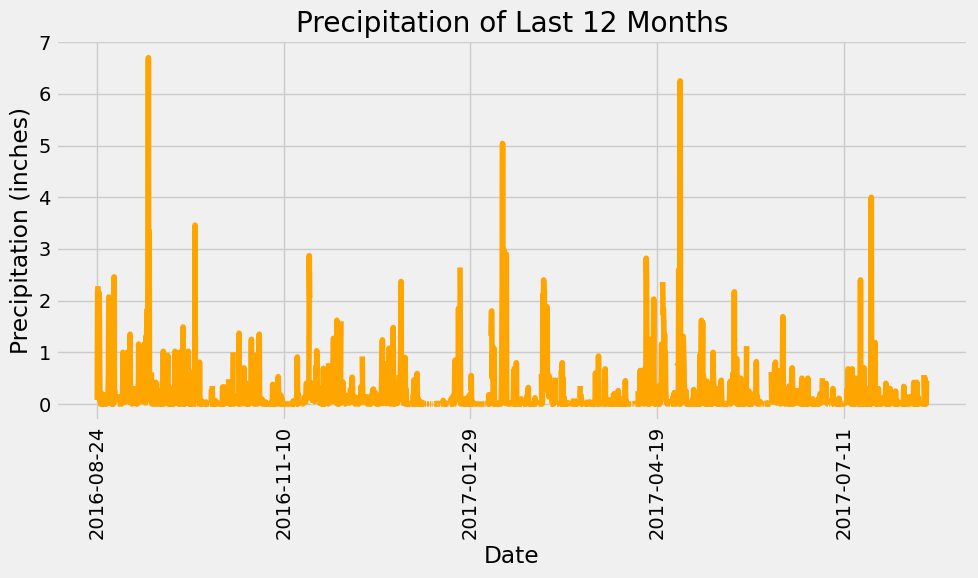

In [54]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

most_recent_date = session.query(func.max(Measurement.date)).scalar()


# Calculate the date one year from the last date in data set.
one_year_ago = dt.datetime.strptime(most_recent_date, '%Y-%m-%d') - dt.timedelta(days=365)


# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()


# Save the query results as a Pandas DataFrame. Explicitly set the column names

df = pd.DataFrame(results, columns=['date', 'precipitation'])

# Sort the dataframe by date

df.set_index('date', inplace=True)
df = df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots(figsize=(10,6))
df.plot(ax=ax, rot=90, legend=False, color='Orange')
ax.set(title="Precipitation of Last 12 Months", xlabel="Date", ylabel="Precipitation (inches)")
plt.tight_layout()
plt.savefig('output/precipitation_bar.png')
plt.show()


In [46]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = df['precipitation'].describe()
print(summary_statistics)


count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64


# Exploratory Station Analysis

In [47]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
print(f"Total number of stations: {total_stations}")


Total number of stations: 9


In [48]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
# List the stations and their counts in descending order.
for station, count in active_stations:
    print(f"Station: {station}, Count: {count}")


Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [49]:
# Get the most active station ID from the previous query
most_active_station = active_stations[0][0]

# Calculate the lowest, highest, and average temperature for the most active station
temperature_stats = session.query(
    func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)
).filter(Measurement.station == most_active_station).all()

lowest_temp, highest_temp, avg_temp = temperature_stats[0]

print(f"Most Active Station: {most_active_station}")
print(f"Lowest Temperature: {lowest_temp}")
print(f"Highest Temperature: {highest_temp}")
print(f"Average Temperature: {avg_temp:.2f}")


Most Active Station: USC00519281
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66


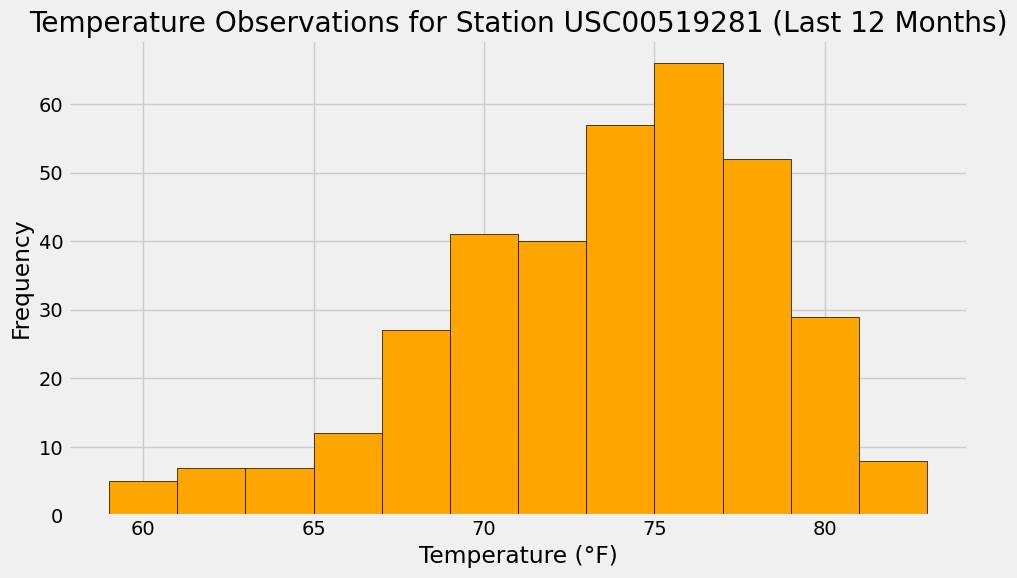

In [55]:
# Calculate the date one year from the last date in data set
one_year_ago = dt.datetime.strptime(most_recent_date, '%Y-%m-%d') - dt.timedelta(days=365)

# Query the last 12 months of temperature observation data for the most active station
temperature_data = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= one_year_ago).all()

# Convert the query results to a list
temperature_data_list = [temp[0] for temp in temperature_data]

# Plot the results as a histogram
plt.figure(figsize=(10, 6))
plt.hist(temperature_data_list, bins=12, color='orange', edgecolor='black')
plt.title(f"Temperature Observations for Station {most_active_station} (Last 12 Months)")
plt.xlabel("Temperature (°F)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig('output/temperature_histogram.png')
plt.show()

# Close Session

In [51]:
# Close Session
session.close()